In [20]:
import pathlib
import os
import torch
import PIL
from PIL import Image
from torch.utils.data import Dataset
from utils import utils
from dataset.dataset import ASLDataset

import torch
from torch import nn
import numpy as np
from torch.optim import Adam
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from utils import utils
from torchvision.transforms import v2
import torch 
import torch.optim as optim

In [21]:
import torchvision
print(torchvision.__version__)

0.16.1+cu121


In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=1)

In [23]:
transform = v2.Compose([
    v2.ToTensor(),
    v2.Grayscale(num_output_channels=3),
    v2.Normalize(mean=[0.5], std=[0.5])  # Gray normalization
])

/home/ibmelab/anaconda3/envs/2scnn/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [24]:
# 1. Load and transform data

train_dir = "archive/asl_alphabet_train/asl_alphabet_train"
train_data_simple = ASLDataset(data_path=train_dir,range_index = [1,2500], transform=transform)
test_data_simple = ASLDataset(data_path=train_dir,range_index = [2501,3000], transform=transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)
print(f'train dataset size :{len(train_data_simple)} images ')
print(f'test dataset size :{len(test_data_simple)} images ')

Creating DataLoader's with batch size 32 and 48 workers.
train dataset size :72471 images 
test dataset size :14471 images 


In [25]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X,XN, y) in enumerate(dataloader):
        # Send data to target device
        X,XN, y = X.to(device),XN.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [26]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,XN,y) in enumerate(dataloader):
            # Send data to target device
            X,XN,y = X.to(device),XN.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [27]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

ValueError: num must be an integer with 1 <= num <= 20, not 30

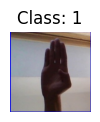

In [36]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define your data path and range index
data_path = "archive/asl_alphabet_train/asl_alphabet_train"
range_index = (1000,1019)  # Specify the range for the first 20 images

# Create an instance of your ASLDataset
dataset = ASLDataset(data_path, range_index, transform=transforms.ToTensor())

# Create a DataLoader to iterate through the dataset
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

# Function to display image pairs consecutively
def display_image_pairs(dataloader, num_pairs=20):
    plt.figure(figsize=(15, 5))
    plt.subplots_adjust(wspace=0.5)

    for i, (img1, img2, class_idx) in enumerate(dataloader):
        if class_idx == 1:
            plt.subplot(2, 10, i+1)
            plt.imshow(transforms.ToPILImage()(img1.squeeze()))
            plt.title(f'Class: {class_idx.item()}')
            plt.axis('off')

            plt.subplot(2, 10, i+11)
            plt.imshow(transforms.ToPILImage()(img2.squeeze()))
            plt.title(f'Class: {class_idx.item()}')
            plt.axis('off')

            if i == num_pairs - 1:
                break

    plt.show()

# Display the image pairs
display_image_pairs(dataloader, num_pairs=20)
